In [1]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter(action='ignore', category=FutureWarning)

### lvl 2 setups (systerm)

import os
import numpy as np
import pandas as pd
import xarray as xr

import matplotlib as mpl
import cartopy.crs as ccrs
import cartopy.feature as cfeature

import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import warnings
warnings.filterwarnings('ignore')
from pylab import *
from matplotlib.colors import ListedColormap,LinearSegmentedColormap
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.patches import Wedge, Circle
import geopandas as gpd
from shapely.geometry import Point
import datetime
import glob

In [2]:
gdf = gpd.read_file('/N/project/Zli_lab/Data/Other/tl_2019_us_state/tl_2019_us_state.shp')
input_folder = '/N/project/Zli_lab/gongg/stage4_data/stage4_daily/'

In [17]:
ds = xr.open_dataset('/N/project/Zli_lab/gongg/stage4_data/stage4_daily/20220615.nc')

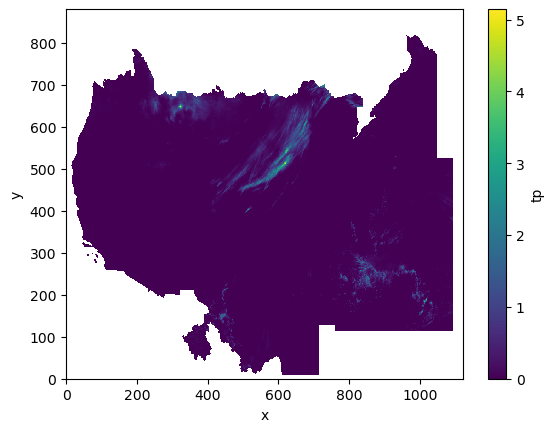

In [21]:
ds.mean('time').tp.plot()

In [15]:
# 提取CONUS数据
lon = ds['lon'].values
lat = ds['lon'].values
grid = gpd.GeoDataFrame(
    geometry=gpd.points_from_xy(lon.flatten(), lat.flatten()),
    index=np.arange(lon.size)
)
grid.set_crs(gdf.crs, inplace=True)
grid_s = gpd.sjoin(grid, gdf, how='inner', predicate='within')

mask = np.full(ds['tp'].shape[1:], False) 
for index in grid_s.index:
    row, col = np.unravel_index(index, mask.shape)  # 获取行列索引
    mask[row, col] = True
mask_da = xr.DataArray(mask, dims=ds['tp'].dims[1:], coords={'y': ds['tp'].coords['y'], 'x': ds['tp'].coords['x']})
ds_s = ds.where(mask_da)
lonn = np.linspace(-124.848, -66.885, 1137)
latt = np.linspace(24.396, 49.384, 708)
prec = ds_s.tp.values
lat_min = latt.min()
lat_max = latt.max()
ds_sss = xr.Dataset({'p': (['time', 'lat', 'lon'], prec)},
                    coords={'lon': (['lon'], lonn),
                            'lat': (['lat'], latt),
                            'time': ('time', ds_s.time.values)})

ValueError: conflicting sizes for dimension 'lon': length 1137 on 'lon' and length 1121 on {'time': 'p', 'lat': 'p', 'lon': 'p'}

In [ ]:
start_year = 2002
end_year = start_year+3
for year in range(start_year, end_year):  

    months = range(6, 9)
    # 遍历月份
    for month in months:
        print(time.strftime('%Y-%m-%d %H:%M:%S', time.localtime()))
        # 获取当前月份的天数
        if month in [7, 8,]:
            num_days = 31
        elif month in [6]:
            num_days = 30
        for day in range(1, num_days + 1):
            
            month_str = f"{month:02}"
            day_str = f"{day:02}"
            input_file = f'{year}{month_str}{day_str}.nc'
            ds = xr.open_mfdataset(input_folder + input_file)
        # 提取CONUS数据
            lon = ds['lon'].values
            lat = ds['lon'].values
            grid = gpd.GeoDataFrame(
                geometry=gpd.points_from_xy(lon.flatten(), lat.flatten()),
                index=np.arange(lon.size)
            )
            grid.set_crs(gdf.crs, inplace=True)
            grid_s = gpd.sjoin(grid, gdf, how='inner', predicate='within')
            
            mask = np.full(ds['PREC_ACC_NC'].shape[1:], False) 
            for index in grid_s.index:
                row, col = np.unravel_index(index, mask.shape)  # 获取行列索引
                mask[row, col] = True
            mask_da = xr.DataArray(mask, dims=ds['PREC_ACC_NC'].dims[1:], coords={'south_north': ds['PREC_ACC_NC'].coords['south_north'], 'west_east': ds['PREC_ACC_NC'].coords['west_east']})
            ds_s = ds.where(mask_da, drop=True)
            lonn = np.linspace(-124.848, -66.885, 1137)
            latt = np.linspace(24.396, 49.384, 708)
            prec = ds_s.PREC_ACC_NC.values
            lat_min = latt.min()
            lat_max = latt.max()
            ds_sss = xr.Dataset({'p': (['time', 'lat', 'lon'], prec)},
                                coords={'lon': (['lon'], lonn),
                                        'lat': (['lat'], latt),
                                        'time': ('time', ds_s.Time.values)})

            original_times = ds_sss.time.values 
            
            lon_ranges = [(-np.inf, -112.5), (-112.5, -97.5), (-97.5, -82.5), (-82.5, np.inf)]
            utc_offsets = [-8, -7, -6, -5]
            
            for (lon_min, lon_max), offset in zip(lon_ranges, utc_offsets):
                mask = (ds_sss.lon >= lon_min) & (ds_sss.lon < lon_max)
                ds_lon_subset = ds_sss.where(mask, drop=True)
                if ds_lon_subset.lat.size > 0 and ds_lon_subset.lon.size > 0:
            
                    adjusted_times = original_times + np.timedelta64(offset, 'h')  # 保持24个时间点
            
                    ds_lon_subset = ds_lon_subset.assign_coords(time=adjusted_times)
            
                    lat_min = ds_lon_subset.lat.min().values
                    lat_max = ds_lon_subset.lat.max().values
            
                    lat_splits = np.linspace(lat_min, lat_max, 10)  # 10个值分9段
            
                    for i in range(len(lat_splits) - 1):
                        lat_min_split = lat_splits[i]
                        lat_max_split = lat_splits[i + 1]
                        lat_mask = (ds_lon_subset.lat >= lat_min_split) & (ds_lon_subset.lat < lat_max_split)
                        ds_lat_subset = ds_lon_subset.where(lat_mask, drop=True)
                        
                        output_folder = '../CONUS404_data/LST/UTC/U' + str(offset)+str(i) + '/'
                        output_file = f'PREC_ACC_NC.wrf2d_d01_{year}-{month_str}-{day_str}.nc'
                        output_path = os.path.join(output_folder, output_file)
                        os.makedirs(output_folder, exist_ok=True)
                        ds_lat_subset.to_netcdf(output_folder + output_file)